# Generation of gravitational wave signals using the <code>pycbc</code> library

This notebook generates a list of binary black hole (BBH) gravitational wave (GW) signals and saves them in either <code>TFRecords</code> files, ready to be read by Tensorflow, or in text files. Data is split into training/validation set - computed in a parallel way and saved in <code>.tfrecords</code> files - and test set - computed serially and saved in <code>.txt</code> files.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import seed
from random import random
import os 
import time
from multiprocessing import Pool
import multiprocessing as mp
import tensorflow.compat.v1 as tf
from tensorflow.python import keras as keras
from tqdm import tqdm
from tqdm.auto import trange
from scipy.interpolate import interp1d
import pylab
from pycbc.waveform import get_td_waveform, get_fd_waveform
import pycbc.noise
import pycbc.psd
import pycbc

import seaborn as sns
plt.style.use("seaborn")

# Set some environment variables to speed up the computation in case of CPU use

NUM_PARALLEL_EXEC_UNITS = 12

# Set the number of threads to use for parallel regions
os.environ["OMP_NUM_THREADS"] = "NUM_PARALLEL_EXEC_UNITS"

# Sets the time, in milliseconds, that a thread should wait, after completing the execution of a parallel region, before sleeping.
os.environ["KMP_BLOCKTIME"] = "30"

# Enables (1) or disables (0) the printing OpenMP run-time library environment variables during program execution.
os.environ["KMP_SETTINGS"] = "1"

# Enables run-time library to bind threads to physical processing units.
# -) Specifying granularity=fine will always cause each OpenMP thread to be bound to a single OS processor.
# -) Specifying compact assigns the OpenMP thread <n>+1 to a free thread context as close as possible to the thread context where the <n> OpenMP 
#    thread was placed. For example, in a topology map, the nearer a node is to the root, the more significance the node has when sorting the threads.
# -) The permute (1) specifier controls which levels are most significant when sorting the machine topology map. A value for permute forces the mappings 
#    to make the specified number of most significant levels of the sort the least significant, and it inverts the order of significance.
# -) The offset specifier indicates the starting position for thread assignment.

os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


Definition of the functions used to generate data, split it into smaller chunks and save it to files.

In [2]:
# Helper functions (see also https://www.tensorflow.org/tutorials/load_data/tf_records)
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def write_tfrecords_file(out_path: str, images: np.ndarray, labels: np.ndarray) -> None:
    # We have a 1-D image in this case: a time-series
    """
    Write all image-label pairs into a single .tfrecord file.
    
    Parameters:
        str out_path: file path of the .tfrecord file to generate or overwrite.
        np.ndarray images: array with first dimension being the image index. Every images[i].tostring() is
                           serialized and written into the file as 'image': wrap_bytes(img_bytes).
        np.ndarray labels: 1d array of integers. labels[i] is the label of images[i]. Written as 'label': wrap_int64(label).
    """
    
    assert len(images) == len(labels)

    with tf.io.TFRecordWriter(out_path) as writer:  # could use writer_options parameter to enable compression
        for i in range(len(labels)):
            img_bytes = images[i].tostring()  # Convert the image to raw bytes.
            label = labels[i]
            data = {'image': tf.train.Feature(float_list=tf.train.FloatList(value=images[i].flatten())), 'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))}
            feature = tf.train.Features(feature=data)  # Wrap the data as TensorFlow Features.
            example = tf.train.Example(features=feature)  # Wrap again as a TensorFlow Example.
            serialized = example.SerializeToString()  # Serialize the data.
            writer.write(serialized)  # Write the serialized data to the TFRecords file.
    
def save_to_tfrecords(fold,samples,train,chunk_number):
    """
    Save training and validation data as TFRecords files.
    
    Parameters:
        str fold: file path of the folder where the .tfrecord file is to be saved.
        list samples: contains data to be saved. See the description of the function
                 signal_generator.
        bool train: specify whether training or test data is being generated.
        int chunk_number: number of the chunk that is being generated.
    """
    n_tot = samples.shape[0]   

    # WARNING: if you want to save samples ordered by SNR, the evaluation samples
    # must be picked with a different pattern, not the first 1/5th
    #np.random.shuffle(samples)

    x_train = np.delete(samples,-1, axis=1)
    x_train = np.delete(x_train,-1, axis=1)
    x_train = np.delete(x_train,-1, axis=1) # time series data
    y_train = samples[:,-3] # labels (0 or 1)
    
    x_train = np.asarray(x_train, dtype= np.float64).reshape(-1, n_timesteps, 1)
    y_train = np.asarray(y_train)

    IMAGE_WIDTH, NUM_OF_IMAGES, NUM_OF_CLASSES = n_timesteps, len(x_train), 2

    features_train = x_train.astype(np.float64)
    labels_train = y_train.astype(np.int) 

    if train:
        rng = np.random.default_rng()
        eval_ind = rng.choice(len(x_train), int(len(x_train)/5), replace=False) # draws random indices to choose for evaluation data
        features_eval = features_train[eval_ind]  # use 1/5 of the total signals as evaluation data
        labels_eval = labels_train[eval_ind] 
        
        write_tfrecords_file(fold+"train_"+str(chunk_number)+".tfrecord", [element for i, element in enumerate(features_train) if i not in eval_ind],\
                                                                          [element for i, element in enumerate(labels_train) if i not in eval_ind])  
        write_tfrecords_file(fold+"eval_"+str(chunk_number)+".tfrecord", features_eval, labels_eval)  # this may take a while. Consider a progressbar
    else:
        write_tfrecords_file(fold+"test_"+str(chunk_number)+".tfrecord", features_train, labels_train)  
        
    return None

def save_to_txt(fold,samples,clean_strain,train,chunk_number):
    """
    Save test data as .txt files.
    
    Parameters:
        str fold: file path of the folder where the .tfrecord file is to be saved.
        list samples: contains data to be saved. See the description of the function
                 signal_generator.
        list samples: contains clean GW signals, whithout noise. See the description of the function
                 signal_generator.
        bool train: specify whether training or test data is being generated.
        int chunk_number: number of the chunk that is being generated.
    """
    n_tot = samples.shape[0]   
 
    np.savetxt(fold+"test_"+str(chunk_number)+".txt", samples)
    np.savetxt(fold+"clean_test_"+str(chunk_number)+".txt", clean_strain)

# Generates training and validation data and saves it on disk
def signal_generator(m1_min,m1_max,m2_min,m2_max,m1_num,m2_num,n_noise,d,fold,train,chunk_number,n_timesteps):
    """
    Computes the specified number of binary black-hole (BBH) gravitational wave (GW) signals in the time domain.
    Data is saved into .tfrecords files, ready to be read by Tensorflow.
    
    Parameters:
        float m1_min: minimum mass of first BH.
        float m1_max: maximum mass of first BH.
        float m2_min: minimum mass of first BH.
        float m2_max: maximum mass of first BH.
        int m1_num: number of masses to sample between m1_min and m1_max.
        int m2_num: number of masses to sample between m2_min and m2_max.
        int n_noise: number of pure noise signals to generate.
        float d: distance of the BBH in Mpc.
        string fold: path of the output file, where data is saved.
        bool train: specify whether training or test data is being generated.
        int chunk_number: number of the chunk that is being generated.
        int n_timesteps: number of timesteps to compute.
        
    Returns:
        samples: list of length (m1_num x m2_num + n_noise) x (n_timesteps + 3). The first
                 m1_num x m2_num rows contain the GW signals, while the other n_noise
                 rows contain the pure noise signals. The first n_timestep columns
                 contain the time series, while the subsequent ones contain the label
                 (1 for GW signals and 0 for pure noise signals), a unique identifier
                 for that signals and the signal-to-noise ratio (SNR), repectively.
        noisy_strain: list of length (m1_num x m2_num) x (n_timesteps + 3). Containts the first
                      m1_num x m2_num rows of samples.
        clean_strain: list of length (m1_num x m2_num) x (n_timesteps + 3). Contains the same signals
                      as in noisy_strain, but without the noise, i.e. the pure GW signals.
        SNR: list of length (m1_num x m2_num + n_noise). Contains the list of the SNR of the signals 
                     contained in noisy_strain.
        pure_noise: list of length (n_noise) x (n_timesteps + 3). Contains the last n_noise rows of
                    samples
        params: list of length (m1_num x m2_num). Contains all the combinations of the two masses.
    """
    params, event, signal, noise, SNR, length = [], [], [], [], [], []

    n_bbh = m1_num*m2_num # total number of samples
    
    m1_list = np.linspace(m1_min,m1_max,m1_num)
    m2_list = np.linspace(m2_min,m2_max,m2_num)
    params = [(x,y) for x in m1_list for y in m2_list] # contains all possible combinations of m1 and m2
    
    # Paramaters for noise generation
    # The color of the noise matches a PSD which you provide
    flow = 30.0 # lowest frequency of the detector noise
    delta_t = 1.0 / n_timesteps # time resolution of the signal
        
    for i in tqdm(range(0,n_bbh)):

        m1 = params[i][0]
        m2 = params[i][1]

        hp, hc = get_td_waveform(approximant='IMRPhenomD', # generates the time-domain strains
                         mass1=m1,
                         mass2=m2,
                         delta_t=delta_t,
                         f_lower=15,
                         distance=d)
        
        hp.start_time+=hp.duration-hp.sample_times[-1] # shifts the event so that it starts at t=0
        hp.start_time-=hp.sample_times[0] 
        
        delta_f = 1.0 / hp.duration
        flen = int(n_timesteps / delta_f) + 1

        psd = pycbc.psd.analytical.aLIGOZeroDetHighPower(flen, delta_f, flow)
        
        # Generating hp.duration seconds of noise at 4096 Hz
        tsamples = int(hp.duration / delta_t)
        ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)
        
        # Resampling event so that it is composed of n_timesteps points and lasts 1 seconds
        time_resampled = np.linspace(hp.duration-0.01-1,hp.duration-0.01,n_timesteps)
        spl = interp1d(hp.sample_times, hp, kind='cubic')
        event_resampled = spl(time_resampled)
        
        spl = interp1d(ts.sample_times, ts, kind='cubic')
        noise_resampled = spl(time_resampled)
        signal_resampled = event_resampled + noise_resampled
        
        sigma = np.std(noise_resampled) # std of the noise
        SNR.append(np.abs(event_resampled).max()/sigma)
        
        # Normalising event, signal to the same max
        event_resampled = event_resampled/1.0e-21
        signal_resampled = signal_resampled/1.0e-21
        
        event.append(event_resampled) # event contains only the clean simulated event (only plus polarisation)
        
        signal.append(signal_resampled) # signal contains the event + noise        

    for i in tqdm(range(0,n_noise)):
        
        # Generating 4 seconds of noise
        tsamples = int(4 / delta_t)
        ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)
        
        time_resampled = np.linspace(0,ts.sample_times[-1],n_timesteps)
        spl = interp1d(ts.sample_times, ts, kind='cubic')
        noise_resampled = spl(time_resampled)
        noise.append(noise_resampled/1.0e-21)
        
    clean_strain = np.real(np.asarray(event, dtype=np.float64).reshape((n_bbh,n_timesteps)))
    noisy_strain = np.real(np.asarray(signal, dtype=np.float64).reshape((n_bbh,n_timesteps)))
    
    SNR = np.real(np.asarray(SNR, dtype=np.float64).reshape((n_bbh,1)))
    pure_noise = np.real(np.asarray(noise, dtype=np.float64).reshape((n_noise,n_timesteps)))

    clean_strain = np.hstack((clean_strain,np.ones((n_bbh,1),dtype=np.int))) # add label 1 to signals
    clean_strain = np.hstack((clean_strain,np.linspace(0,n_bbh-1,n_bbh).reshape(n_bbh,1))) # add unique identifier for all signals

    noisy_strain = np.hstack((noisy_strain,np.ones((n_bbh,1),dtype=np.int))) # add label 1 to signals
    noisy_strain = np.hstack((noisy_strain,np.linspace(0,n_bbh-1,n_bbh).reshape(n_bbh,1))) # add unique identifier for all signals
    noisy_strain = np.hstack((noisy_strain,SNR)) # add SNR feature

    pure_noise = np.hstack((pure_noise,np.zeros((n_noise,1),dtype=np.int))) # add label 0 to pure noise
    pure_noise = np.hstack((pure_noise,np.zeros((n_noise,1)))) # add 1 placeholder column to match dimensions with noisy_strain
    pure_noise = np.hstack((pure_noise,np.zeros((n_noise,1)))) # add SNR feature (=0 for noise)

    samples = np.vstack((noisy_strain,pure_noise))

    # Ordering by decreasing SNR
    ind_samples = (-samples[:,-1]).argsort() 
    samples = samples[ind_samples]
    
    ind_noisy_strain = (-noisy_strain[:,-1]).argsort() 
    noisy_strain = noisy_strain[ind_noisy_strain]
    clean_strain = clean_strain[ind_noisy_strain]
    
    ind_SNR = (-SNR[:,-1]).argsort() 
    SNR = SNR[ind_SNR]
    
    if train:
        # Saving data to TFRecords files
        save_to_tfrecords(fold,samples,train,chunk_number)
    else:
        save_to_txt(fold,samples,clean_strain,train,chunk_number)
    
    return samples, noisy_strain, clean_strain, SNR, pure_noise, params

def data_generator(n_chunks,n_bbh,n_noise,parallel,n_procs,d0):
    """
    Splits the data to be generated into chunks and generates the data. The specified
    n_bbh + n_noise number of signals is generated at increasing distances, one for each
    chunk, so that in total (n_bbh + n_noise) x n_chunks are generated.
    
    Parameters:
        int n_cunks: number of chunks into which to split the data. For now
                     it is set to n_procs, so that each process generates a
                     chunk.
        int n_bbh: total number of GW signals to be generated.
        int n_noise: number of pure noise signal to be generated.
        bool parallel: if True splits the data generating process into
                       n_procs processes. If False, data is generated
                       in a serial way.
        int n_procs: number of processed to spawn if parallel=True.
        int d0: lowest distance that is being used to generate data.
        
    Returns:
        samples: list of length (m1_num x m2_num + n_noise) x (n_timesteps + 3). The first
                 m1_num x m2_num rows contain the GW signals, while the other n_noise
                 rows contain the pure noise signals. The first n_timestep columns
                 contain the time series, while the subsequent ones contain the label
                 (1 for GW signals and 0 for pure noise signals), a unique identifier
                 for that signals and the signal-to-noise ratio (SNR), repectively.
        noisy_strain: list of length (m1_num x m2_num) x (n_timesteps + 3). Containts the first
                      m1_num x m2_num rows of samples.
        clean_strain: list of length (m1_num x m2_num) x (n_timesteps + 3). Contains the same signals
                      as in noisy_strain, but without the noise, i.e. the pure GW signals.
        SNR: list of length (m1_num x m2_num + n_noise). Contains the list of the SNR of the signals 
                     contained in noisy_strain.
        pure_noise: list of length (n_noise) x (n_timesteps + 3). Contains the last n_noise rows of
                    samples
        params: list of length (m1_num x m2_num). Contains all the combinations of the two masses.
    
    """
    if(n_bbh%n_chunks!=0):
        raise Exception('ERROR: n_bbh must be divisible by n_chunks.\n')
        
    print('\n Number of data chunks: ',n_chunks,'.\n')
    print('\n Number of signals + noises in each chunk: ',n_bbh,' signals + ',n_noise,' noises. \n')

    # Generating data
    print("\n Generating data... \n")

    if parallel:
    
        start_time = time.time()
        p = Pool(n_procs)

        data = [(m1_min,m1_max,m2_min,m2_max,m1_num,m2_num,n_noise,d0*(1+i*0.1),fold,train,i,n_timesteps) for i in range(0,n_chunks)]
        results = p.starmap(signal_generator, data)

        p.close()
        
        results = np.asarray(results)

        samples,noisy_strain,clean_strain,SNR,pure_noise,params = [], [], [], [], [], []
        
        print("Formatting data.\n")
        for i in tqdm(range(n_chunks)):
                    
            samples_new = results[i][0]
            noisy_strain_new = results[i][1]
            clean_strain_new = results[i][2]
            SNR_new = results[i][3]
            pure_noise_new = results[i][4]
            params_new = results[i][5]
        
            
            if i==0:
                samples = samples_new
                noisy_strain = noisy_strain_new
                clean_strain = clean_strain_new
                SNR = SNR_new
                pure_noise = pure_noise_new
                params = params_new
            else:
                samples = np.vstack((samples,samples_new))
                noisy_strain = np.vstack((noisy_strain,noisy_strain_new))
                clean_strain = np.vstack((clean_strain,clean_strain_new))
                SNR = np.vstack((SNR,SNR_new))
                pure_noise = np.vstack((pure_noise,pure_noise_new))
                params = np.vstack((params,params_new))


        end_time = time.time()
        print("\n Data generated and saved. It took ",end_time-start_time,"s. \n")
        
    else:
        
        start_time = time.time()
        for i in range(0,n_chunks):
            print('Computing chunk number ',i+1,'/',n_chunks)
            samples_new, noisy_strain_new, clean_strain_new, SNR_new, pure_noise_new, params_new = signal_generator(m1_min,m1_max,m2_min,m2_max,m1_num,m2_num,n_noise,d0*(1+i*0.3),fold,train,i,n_timesteps)
            if i==0:
                samples, noisy_strain, clean_strain, SNR, pure_noise, params = samples_new, noisy_strain_new, clean_strain_new, SNR_new, pure_noise_new, params_new
            else:
                samples = np.vstack((samples,samples_new))
                noisy_strain = np.vstack((noisy_strain,noisy_strain_new))
                clean_strain = np.vstack((clean_strain,clean_strain_new))
                SNR = np.vstack((SNR,SNR_new))
                pure_noise = np.vstack((pure_noise,pure_noise_new))
                params = np.vstack((params,params_new))
        end_time = time.time()
        print("\n Data generated and saved. It took ",end_time-start_time,"s. \n")
        
    return samples,noisy_strain,clean_strain,SNR,pure_noise,params

## Training and validation data

In [3]:
# Setting the parameters for training and validation data

#seed(2) # setting the seed for random()
#np.random.seed(2) # setting the seed for np.random.normal()

n_procs = mp.cpu_count() # number of processes to spawn
n_chunks = n_procs #100 # number of chunks into which we divide the data

m1_min = 10
m1_max = 30

m2_min = 10
m2_max = 30

m1_num = 10
m2_num = 12
n_bbh = m1_num*m2_num
n_noise = n_bbh
# n_noise = int(n_bbh/3)

n_timesteps = 4096 # number of time points

d0 = 10000 # minimum distance (in Mpc)

parallel = True 

# Folder where training and validation data is saved
fold = '/mnt/c/Users/solda/Documents/code/ML/mycnn_gw/new/trvaldata/'

train=True

f=open(fold+'config.txt', 'w')
np.savetxt(f, [n_timesteps], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_bbh+n_noise], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_bbh], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_noise], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_chunks], delimiter=" ", fmt='%10.0d')
f.close() 

In [4]:
# Generate and save training and validation data
if __name__ == '__main__':
    
    samples, noisy_strain, clean_strain, SNR, pure_noise, params = data_generator(n_chunks,n_bbh,n_noise,parallel,n_procs,d0)



 Number of data chunks:  12 .


 Number of signals + noises in each chunk:  120  signals +  120  noises. 


 Generating data... 



100%|██████████| 120/120 [00:03<00:00, 34.12it/s]
/home/soldaman93/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 120/120 [00:03<00:00, 37.74it/s]
/home/soldaman93/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 120/120 [00:03<00:00, 38.39it/s]
/home/soldaman93/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 120/120 [00:02<00:00, 45.67it/s]
/home/soldaman93/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/home/soldaman93/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays 

Formatting data.



100%|██████████| 12/12 [00:00<00:00, 48.18it/s]


 Data generated and saved. It took  41.68034791946411 s. 



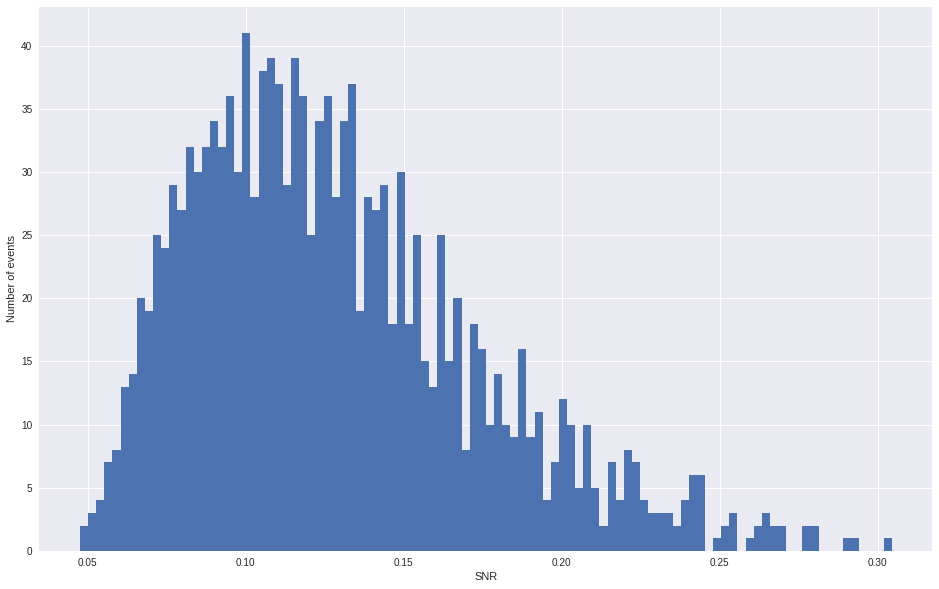

In [5]:
# Plot the SNR distribution of training/validation data
fig = plt.figure(figsize=(16,10))
plt.hist(SNR,bins=100)
plt.xlabel('SNR')
plt.ylabel('Number of events')
plt.show()
fig.savefig(fold+'snr_distribution.png', bbox_inches='tight', pad_inches=0.5, format='png')

SNR =  0.04756953112980812


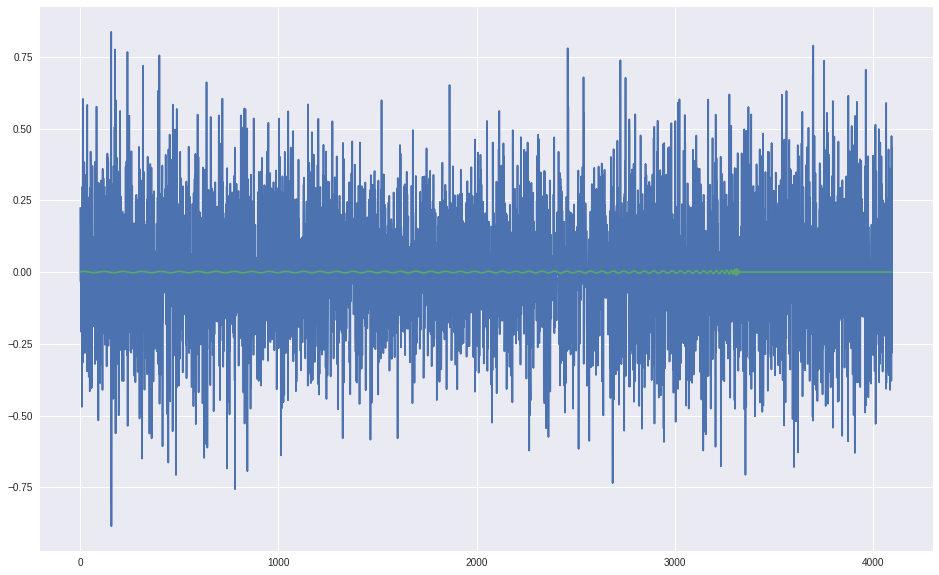

In [6]:
# Plot a specific signal
# Events are stored inside clean_strain and are
# ordered by decreasing SNR

#i_chunk = 0 # index of the chunk
#i_samples = 0
#i_noisy_strain = 1
#i_clean_strain = 2

i_sig = -1 # index of the signal 

event = clean_strain[i_sig][:-2]
signal = noisy_strain[i_sig][:-3]
noise = signal-event    

sigma = np.std(noise) # std of the noise

# print('SNR = ',np.max(np.abs(event))/np.sqrt(np.mean(noise**2))) # SNR
# print('SNR = ',np.max(np.abs(event))/sigma)
print('SNR = ',noisy_strain[i_sig][-1])

fig = plt.figure(figsize=(16,10))
plt.plot(signal)
plt.plot(event)
#plt.plot(noise)
#plt.xlim(6600,6700)

# Test data

In [7]:
# Setting the parameters for test data

#seed(3) # setting the seed for random()
#np.random.seed(3) # setting the seed for np.random.normal()

n_procs = mp.cpu_count() # number of processes to spawn
n_chunks = n_procs#100 # number of chunks into which we divide the data

m1_min = 10
m1_max = 30

m2_min = 10
m2_max = 30

m1_num = 12
m2_num = 6
n_bbh = m1_num*m2_num#-(m1_num*m2_num)%n_procs
n_noise = n_bbh

n_timesteps = 4096 # number of time points

d0 = 10000 # minimum distance (in Mpc)

parallel = True

# Folder where test data is saved
fold = '/mnt/c/Users/solda/Documents/code/ML/mycnn_gw/new/testdata/'

train=False

f=open(fold+'config.txt', 'w')
np.savetxt(f, [n_timesteps], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_bbh+n_noise], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_bbh], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_noise], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_chunks], delimiter=" ", fmt='%10.0d')
f.close() 

In [8]:
# Generate and save test data
if __name__ == '__main__':
    
    samples, noisy_strain, clean_strain, SNR, pure_noise, params = data_generator(n_chunks,n_bbh,n_noise,parallel,n_procs,d0)



 Number of data chunks:  12 .


 Number of signals + noises in each chunk:  72  signals +  72  noises. 


 Generating data... 



100%|██████████| 72/72 [00:02<00:00, 31.92it/s]
/home/soldaman93/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 12/12 [00:00<00:00, 82.11it/s]

Formatting data.


 Data generated and saved. It took  27.624325037002563 s. 



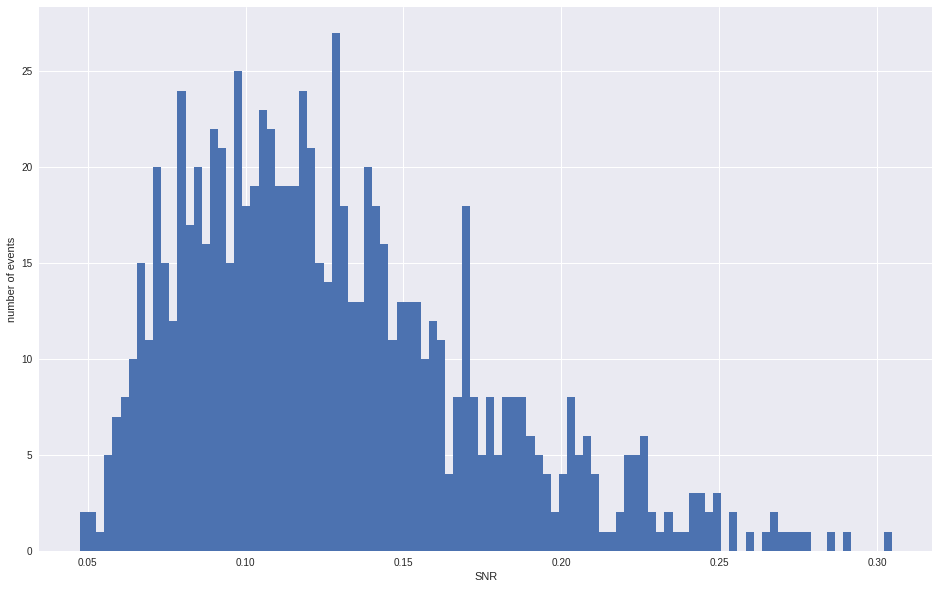

In [9]:
# Plot the SNR distribution of test data
fig = plt.figure(figsize=(16,10))
plt.hist(SNR,bins=100)
plt.xlabel('SNR')
plt.ylabel('number of events')
plt.show()
fig.savefig(fold+'snr_distribution.png', bbox_inches='tight', pad_inches=0.5, format='png')

SNR =  0.304649626781456


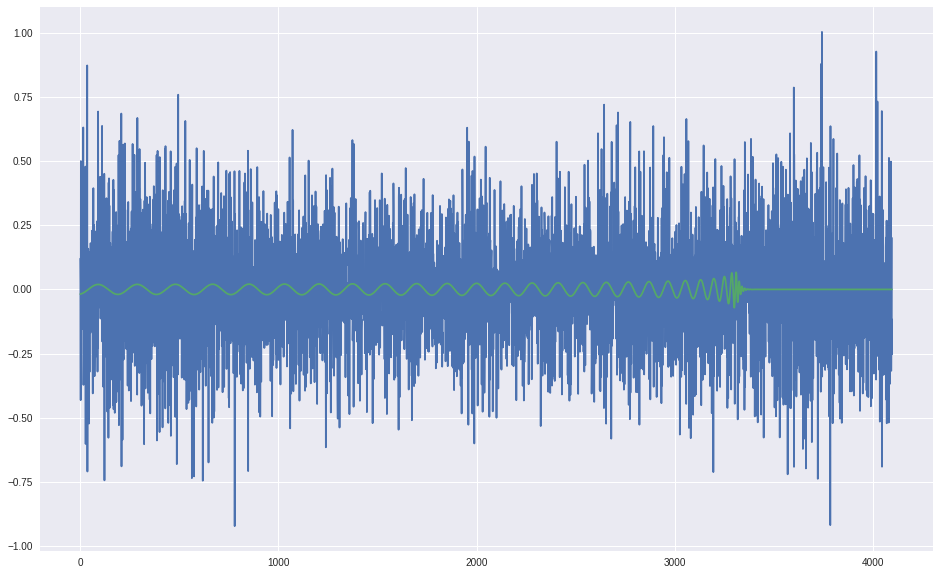

In [12]:
# Plot a specific signal
# Events are stored inside clean_strain and are
# ordered by decreasing SNR

#i_chunk = 0 # index of the chunk
#i_samples = 0
#i_noisy_strain = 1
#i_clean_strain = 2
i_sig = 0 # index of the signal inside the chunk

event = clean_strain[i_sig][:-2]
signal = noisy_strain[i_sig][:-3]
noise = signal-event    

sigma = np.std(noise) # std of the noise

# print('SNR = ',np.max(np.abs(event))/np.sqrt(np.mean(noise**2))) # SNR
# print('SNR = ',np.max(np.abs(event))/sigma)
print('SNR = ',noisy_strain[i_sig][-1])

fig = plt.figure(figsize=(16,10))

plt.plot(signal)
plt.plot(event)

Use this cell to convert the notebook to a python script.

In [11]:
# To convert the notebook to a python script

# !jupyter nbconvert --to script data_generator.ipynb